In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm


In [2]:

class_names = ['anemic', 'Non-anemic']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
IMAGE_SIZE = (224, 224)

def load_data():
   
    dataset_dir ='D:/datasets/Anemia Detection using Palpable Palm Image Datasets from Ghana/Anemia Detection using Palpable Palm Image Datasets from Ghana/Palm/Palm'
    images = []
    labels = []

    print("Loading dataset...")

    for folder in os.listdir(dataset_dir):
        label = class_names_label[folder]

        for file in tqdm(os.listdir(os.path.join(dataset_dir, folder))):

            img_path = os.path.join(os.path.join(dataset_dir, folder), file)

            image = cv2.imread(img_path)
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert to HSV
            image_resized = cv2.resize(hsv_image, IMAGE_SIZE)

            images.append(image_resized)
            labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    images, labels = shuffle(images, labels, random_state=25)

    # Split the data: 75% train, 10% validation, 15% test
    split_1 = int(0.75 * len(images))
    split_2 = int(0.85 * len(images))

    train_images = images[:split_1]
    train_labels = labels[:split_1]

    val_images = images[split_1:split_2]
    val_labels = labels[split_1:split_2]

    test_images = images[split_2:]
    test_labels = labels[split_2:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data()


Loading dataset...


100%|██████████| 1698/1698 [00:08<00:00, 205.90it/s]


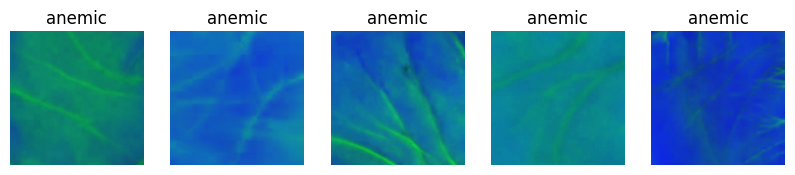

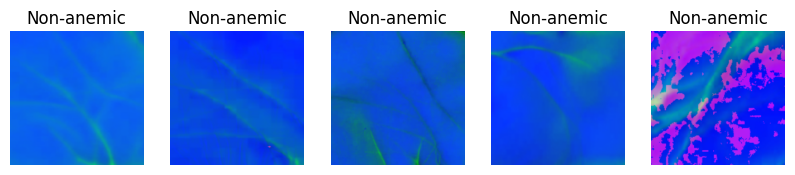

In [3]:
import matplotlib.pyplot as plt

def plot_class_images(images, labels, class_label, class_name, num_images=5):
    """
    Plots the first num_images images from the given class.
    """
    idxs = [i for i, label in enumerate(labels) if label == class_label][:num_images]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(idxs):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].astype('uint8'))
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Plot 5 images of class 'anemic' (label 0) and 5 images of class 'Non-anemic' (label 1)
plot_class_images(train_images, train_labels, class_label=0, class_name='anemic')
plot_class_images(train_images, train_labels, class_label=1, class_name='Non-anemic')


In [5]:
from tensorflow.keras.applications.densenet import preprocess_input

train_images = preprocess_input(train_images)
val_images = preprocess_input(val_images)
test_images = preprocess_input(test_images)

n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))
print("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 3194
Number of validation examples: 426
Number of testing examples: 639
Each image is of size: (224, 224)


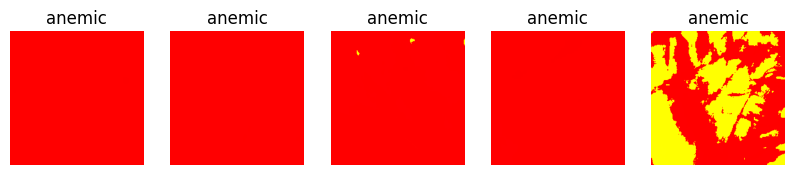

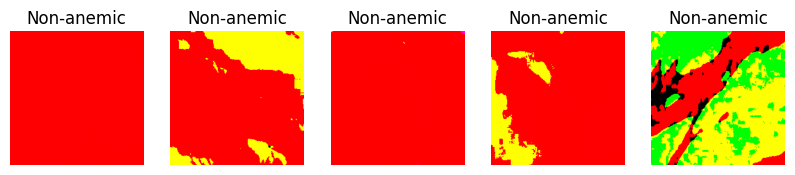

In [6]:
import matplotlib.pyplot as plt

def plot_class_images(images, labels, class_label, class_name, num_images=5):
    """
    Plots the first num_images images from the given class.
    """
    idxs = [i for i, label in enumerate(labels) if label == class_label][:num_images]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(idxs):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].astype('uint8'))
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Plot 5 images of class 'anemic' (label 0) and 5 images of class 'Non-anemic' (label 1)
plot_class_images(train_images, train_labels, class_label=0, class_name='anemic')
plot_class_images(train_images, train_labels, class_label=1, class_name='Non-anemic')


In [7]:
# DenseNet Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load pre-trained DenseNet121
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze fewer layers to allow the model to learn new features
for layer in base_model.layers[:300]:  # Freeze first 300 layers
    layer.trainable = False

# Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)






In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_densemodel_lab.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [9]:
# Train the model
history = model.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=30,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/30
100/100 [==============================] - 325s 3s/step - loss: 0.6381 - accuracy: 0.6888 - val_loss: 0.4795 - val_accuracy: 0.8146
Epoch 2/30
100/100 [==============================] - 358s 4s/step - loss: 0.2809 - accuracy: 0.8842 - val_loss: 0.2477 - val_accuracy: 0.9131
Epoch 3/30
100/100 [==============================] - 333s 3s/step - loss: 0.1420 - accuracy: 0.9534 - val_loss: 0.1631 - val_accuracy: 0.9484
Epoch 4/30
100/100 [==============================] - 315s 3s/step - loss: 0.0724 - accuracy: 0.9793 - val_loss: 0.1010 - val_accuracy: 0.9624
Epoch 5/30
100/100 [==============================] - 318s 3s/step - loss: 0.0378 - accuracy: 0.9909 - val_loss: 0.0774 - val_accuracy: 0.9718
Epoch 6/30
100/100 [==============================] - 314s 3s/step - loss: 0.0334 - accuracy: 0.9894 - val_loss: 0.0709 - val_accuracy: 0.9765
Epoch 7/30
100/100 [==============================] - 308s 3s/step - loss: 0.0275 - accuracy: 0.9934 - val_loss: 0.0933 - val_accuracy: 0.9695

In [11]:
model.load_weights('best_densemodel_lab.h5')
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.2%}")

20/20 [==============================] - 43s 2s/step - loss: 0.0921 - accuracy: 0.9844
Test Accuracy: 98.44%


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Predict probabilities
predictions = model.predict(test_images)

# Convert probabilities to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))


20/20 [==============================] - 43s 2s/step
Classification Report:
              precision    recall  f1-score   support

      anemic       0.99      0.98      0.99       392
  Non-anemic       0.97      0.99      0.98       247

    accuracy                           0.98       639
   macro avg       0.98      0.98      0.98       639
weighted avg       0.98      0.98      0.98       639



In [13]:
precision = precision_score(test_labels, predicted_labels)
print(f'Precision: {precision}')

recall = recall_score(test_labels, predicted_labels)
print(f'Recall: {recall}')

f1 = f1_score(test_labels, predicted_labels)
print(f'F1 Score: {f1}')

Precision: 0.9721115537848606
Recall: 0.9878542510121457
F1 Score: 0.9799196787148595


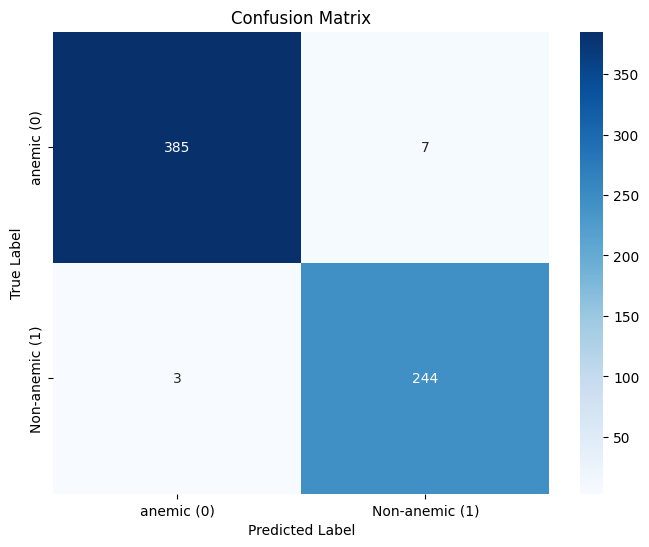

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Define class names with the correct labels
class_names = ['anemic (0)', 'Non-anemic (1)']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


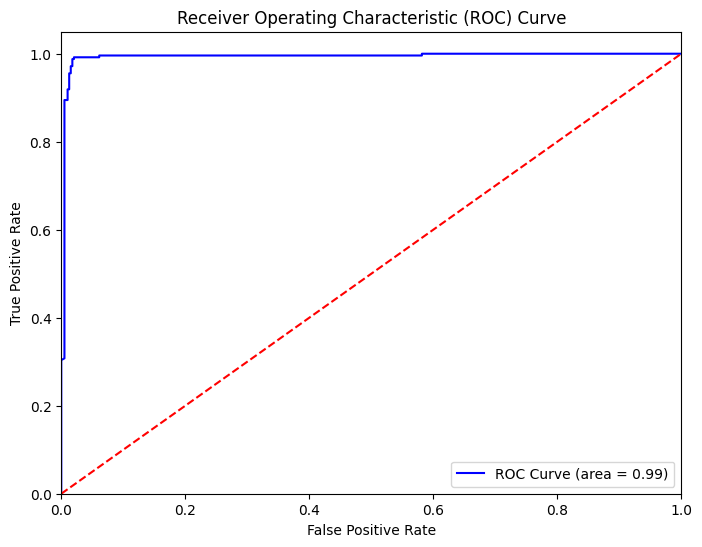

In [15]:
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
roc_auc = roc_auc_score(test_labels, predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

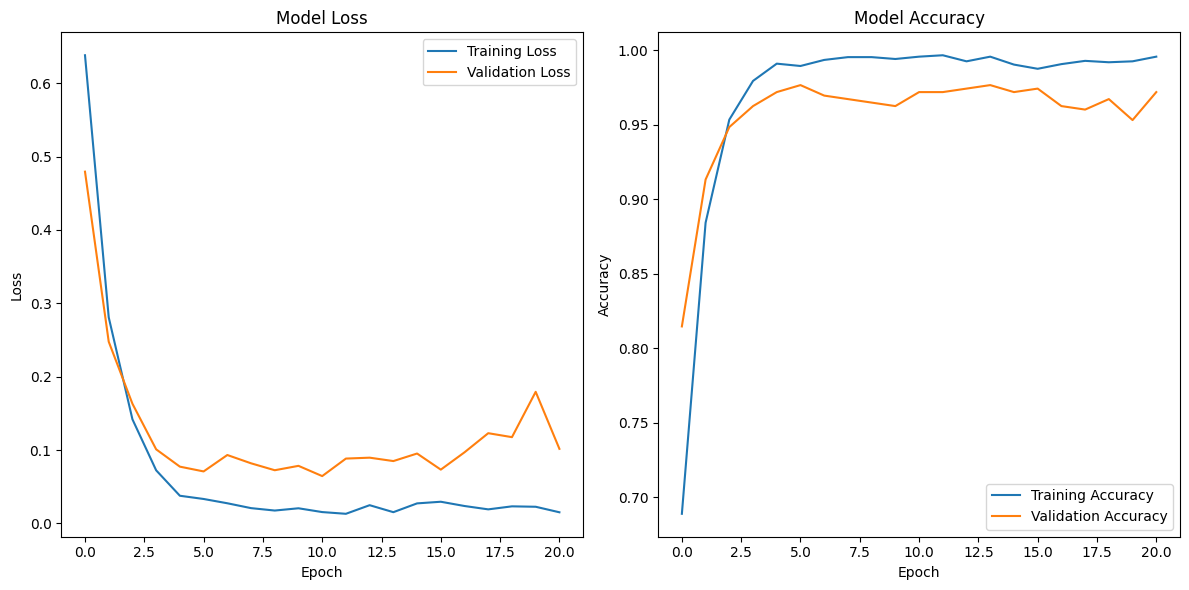

In [16]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
model.save('palm_densenetnewacc.h5')